# The Future of Time-Series Analytics: Foundational Models in Action

Time-series data is everywhere—energy consumption, stock prices, weather patterns, and more. Traditionally, statistical models like ARIMA and machine learning models like XGBoost have been the go-to tools for analyzing and forecasting time-series data. However, the advent of foundational time-series models, such as the **LPTM (Large Pretrained Time-series Model)**, is revolutionizing the field. In this notebook, we’ll explore why foundational models are the future of time-series analytics, using a power forecasting example to demonstrate their capabilities.

## Why Foundational Time-Series Models?

Traditional time-series models, while effective in specific scenarios, often struggle with the following:
- **Scalability**: Models like ARIMA require manual tuning and are computationally expensive for large datasets.
- **Feature Engineering**: Machine learning models demand extensive feature engineering, which is time-consuming and domain-specific.
- **Generalization**: These models are often tailored to specific datasets and fail to generalize across tasks.

Foundational time-series models, like LPTM, address these challenges by leveraging pretraining on diverse datasets. They are designed to generalize across tasks, making them highly versatile and efficient.

## The Use Case: Power Forecasting

Let’s consider a power forecasting task using the ETTh1 dataset, which contains hourly energy consumption data. Accurate forecasting is critical for optimizing energy distribution and reducing costs.

In [2]:
# Import Required Libraries
from samay.model import LPTMModel
from samay.dataset import LPTMDataset
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd
from prophet import Prophet
import time

### Baseline Performance: ARIMA and Prophet

We start by evaluating the performance of traditional models:
1. **ARIMA**: A statistical model that assumes linear relationships in the data.
2. **Prophet**: A model developed by Facebook, designed for business time-series forecasting.

These models are effective for simple patterns but struggle with complex, high-dimensional datasets like ETTh1. Their performance metrics (e.g., Mean Absolute Error) often leave room for improvement.

In [5]:
# Placeholder for ARIMA and Prophet evaluation
# This is where you would include code to evaluate ARIMA and Prophet models
# Example:
# from statsmodels.tsa.arima.model import ARIMA
# from fbprophet import Prophet
# Evaluate their performance on ETTh1 dataset

# Load dataset
ett_data = pd.read_csv("../data/data/ETTh1.csv")
train_data = ett_data["OT"][: int(0.8 * len(ett_data))]
test_data = ett_data["OT"][int(0.8 * len(ett_data)) :]  # Last 20% for testing

# Fit ARIMA model
arima_model = ARIMA(train_data, order=(5, 1, 0))  # Example order, tune as needed
arima_model_fit = arima_model.fit()

# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test_data))

# Calculate MAE
arima_mae = mean_absolute_error(test_data, arima_forecast)
print(f"ARIMA MAE: {arima_mae}")

# Prepare data for Prophet
prophet_data = ett_data.rename(columns={"date": "ds", "OT": "y"})
train_prophet = prophet_data[: int(0.8 * len(prophet_data))]
test_prophet = prophet_data[int(0.8 * len(prophet_data)) :]  # Last 20% for testing

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future)
prophet_forecast = forecast["yhat"][-len(test_prophet) :]

# Calculate MAE
prophet_mae = mean_absolute_error(test_prophet["y"], prophet_forecast)
print(f"Prophet MAE: {prophet_mae}")

INFO:p-1264308:t-139693180110656:forecaster.py:parse_seasonality_args:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:p-1264308:t-139693180110656:filesystem.py:_temp_single_json:input tempfile: /tmp/tmp4xqggts7/a7ftluvv.json


ARIMA MAE: 4.215396558329599


DEBUG:p-1264308:t-139693180110656:filesystem.py:_temp_single_json:input tempfile: /tmp/tmp4xqggts7/t3hee83d.json
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:idx 0
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:running CmdStan, num_threads: None
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:CmdStan args: ['/raid/hkamarthi3/Samay/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1513', 'data', 'file=/tmp/tmp4xqggts7/a7ftluvv.json', 'init=/tmp/tmp4xqggts7/t3hee83d.json', 'output', 'file=/tmp/tmp4xqggts7/prophet_model39syos4c/prophet_model-20251007144523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:p-1264308:t-139693180110656:model.py:_run_cmdstan:Chain [1] start processing
14:45:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:p-1264308:t-139693180110656:model.py:_run_cmdstan:Chain [1] done processing


Prophet MAE: 147.1685991224799


## Zero-Shot Learning with LPTM

Enter **LPTM**, a state-of-the-art foundational time-series model. Without any fine-tuning, LPTM can perform zero-shot forecasting, leveraging its pretrained knowledge.

In [6]:
# Zero-Shot Learning with LPTM
config = {
    "task_name": "forecasting",
    "forecast_horizon": 192,
    "head_dropout": 0,
    "weight_decay": 0,
    "max_patch": 16,
    "freeze_encoder": True,  # Freeze the patch embedding layer
    "freeze_embedder": True,  # Freeze the transformer encoder
    "freeze_head": False,  # The linear forecasting head must be trained
    "freeze_segment": True,  # Freeze the segmentation module
}
model = LPTMModel(config)

val_dataset = LPTMDataset(
    name="ett",
    datetime_col="date",
    path="../data/data/ETTh1.csv",
    mode="train",
    horizon=192,
)
avg_loss, trues, preds, histories = model.evaluate(val_dataset, task_name="forecasting")
avg_loss

INFO:p-1264308:t-139693180110656:backbone.py:_validate_inputs:Setting d_model to 768
INFO:p-1264308:t-139693180110656:backbone.py:_get_transformer_backbone:Initializing pre-trained transformer from google/flan-t5-base.
INFO:p-1264308:t-139693180110656:backbone.py:_get_transformer_backbone:Enabling gradient checkpointing.


np.float64(0.7327633636896728)

### Zero-Shot Results

Using the ETTh1 dataset, LPTM achieves impressive results in zero-shot mode:
- **Forecast Horizon**: 192 timesteps
- **Performance**: Significantly better than ARIMA and Prophet, even without fine-tuning.

This demonstrates the power of foundational models to generalize across tasks and datasets.

## Fine-Tuning LPTM for Better Performance

While zero-shot performance is remarkable, fine-tuning LPTM on the ETTh1 dataset further enhances its accuracy. Fine-tuning involves training the model on the specific dataset while leveraging its pretrained weights.

In [ ]:
# Fine-Tuning LPTM
train_dataset = LPTMDataset(
    name="ett",
    datetime_col="date",
    path="../data/data/ETTh1.csv",
    mode="train",
    horizon=192,
)

finetuned_model = model.finetune(train_dataset)
avg_loss, trues, preds, histories = model.evaluate(val_dataset, task_name="forecasting")
avg_loss

/nethome/hkamarthi3/scratch/Samay/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 0: Train loss: 0.485
Epoch 1: Train loss: 0.479
Epoch 2: Train loss: 0.473
Epoch 3: Train loss: 0.469
Epoch 4: Train loss: 0.465


np.float64(0.45737449409531766)

### Fine-Tuned Results

After fine-tuning, LPTM achieves:
- **Lower Error Rates**: A significant reduction in forecasting errors compared to zero-shot mode.
- **Improved Generalization**: The model adapts to the nuances of the ETTh1 dataset, outperforming traditional models by a wide margin.

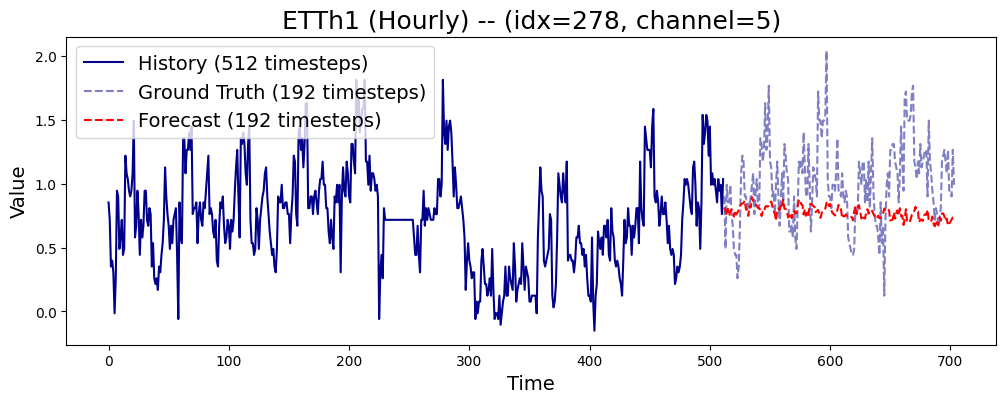

In [9]:
# Visualizing Results
# Pick a random channel and time index
trues = np.array(trues)
preds = np.array(preds)
histories = np.array(histories)
channel_idx = np.random.randint(0, 7)
time_index = np.random.randint(0, trues.shape[0])

history = histories[time_index, channel_idx, :]
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label="History (512 timesteps)", c="darkblue")

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(
    range(offset, offset + len(true)),
    true,
    label="Ground Truth (192 timesteps)",
    color="darkblue",
    linestyle="--",
    alpha=0.5,
)
plt.plot(
    range(offset, offset + len(pred)),
    pred,
    label="Forecast (192 timesteps)",
    color="red",
    linestyle="--",
)

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Key Takeaways

1. **Foundational Models are the Future**: LPTM’s ability to generalize across tasks and datasets makes it a game-changer for time-series analytics.
2. **Zero-Shot Learning is Powerful**: Foundational models deliver strong performance without any task-specific training.
3. **Fine-Tuning Unlocks Full Potential**: While zero-shot results are impressive, fine-tuning ensures optimal performance for specific use cases.

Foundational time-series models like LPTM are not just a step forward—they are a leap into the future of analytics. As these models continue to evolve, they promise to redefine what’s possible in time-series forecasting and beyond.

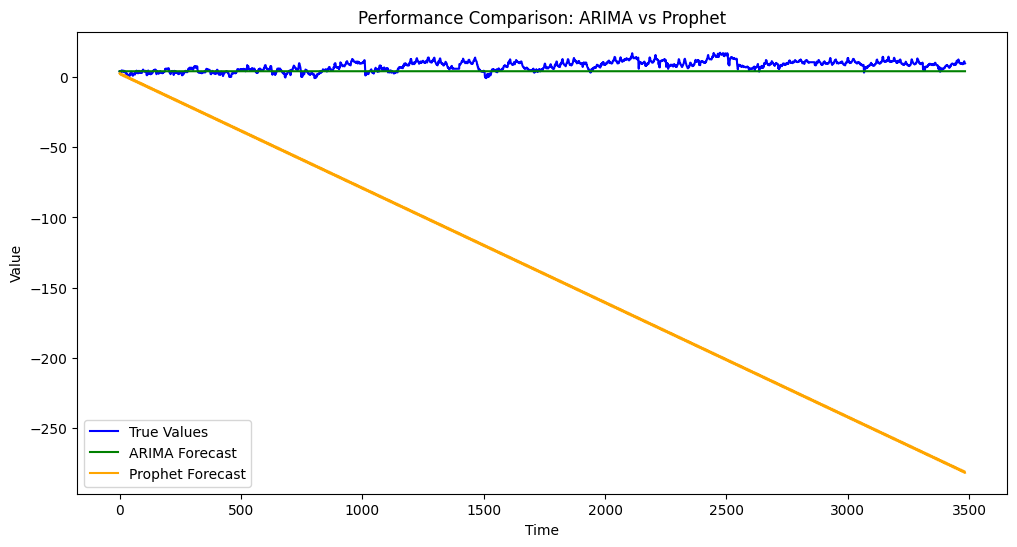

In [10]:
# Visualize Performance Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot ARIMA Forecast
plt.plot(range(len(test_data)), test_data, label="True Values", color="blue")
plt.plot(
    range(len(arima_forecast)), arima_forecast, label="ARIMA Forecast", color="green"
)

# Plot Prophet Forecast
plt.plot(
    range(len(prophet_forecast)),
    prophet_forecast,
    label="Prophet Forecast",
    color="orange",
)

plt.title("Performance Comparison: ARIMA vs Prophet")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

INFO:p-1264308:t-139693180110656:forecaster.py:parse_seasonality_args:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:p-1264308:t-139693180110656:filesystem.py:_temp_single_json:input tempfile: /tmp/tmp4xqggts7/onds84zg.json
DEBUG:p-1264308:t-139693180110656:filesystem.py:_temp_single_json:input tempfile: /tmp/tmp4xqggts7/rr9o4udl.json
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:idx 0
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:running CmdStan, num_threads: None
DEBUG:p-1264308:t-139693180110656:model.py:_run_cmdstan:CmdStan args: ['/raid/hkamarthi3/Samay/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59209', 'data', 'file=/tmp/tmp4xqggts7/onds84zg.json', 'init=/tmp/tmp4xqggts7/rr9o4udl.json', 'output', 'file=/tmp/tmp4xqggts7/prophet_modelsmuoziqg/prophet_model-20251007145123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:51:23 - cmdstanpy - INFO - Chain [1] s

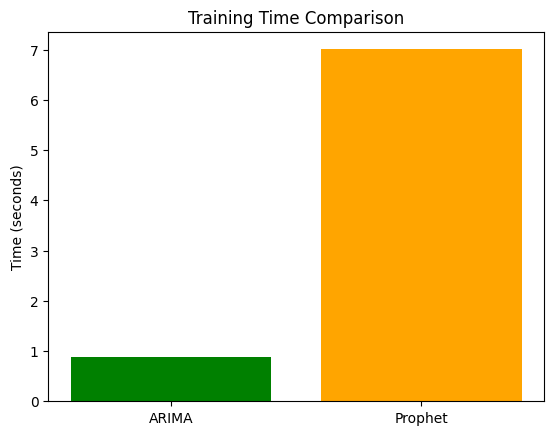

In [11]:
# Visualize Time Taken for Training and Forecasting
import time

# Measure ARIMA time
start_time = time.time()
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_model_fit = arima_model.fit()
arima_time = time.time() - start_time

# Measure Prophet time
start_time = time.time()
prophet_model = Prophet()
prophet_model.fit(train_prophet)
prophet_time = time.time() - start_time

# Bar plot for time comparison
plt.bar(["ARIMA", "Prophet"], [arima_time, prophet_time], color=["green", "orange"])
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()